## Overview
This code supports the discussion in Section 3.3 of the paper. It generates Figure 5 which compare the modelled and recorded data for the West Phoenix flux tower dataset.

In [38]:
#-- Import general libraries
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import xarray as xr
import matplotlib.pyplot as plt
import math
from matplotlib.transforms import ScaledTranslation
# Time in UTC
ds_era5_corrected = xr.open_dataset('US-WestPhoenix_era5_corrected_v1.nc')
ds_cleanobs = xr.open_dataset('US-WestPhoenix_clean_observations_v1.nc')

In [39]:
Nt = 150
no_periods = Nt+1
daterange_UTC = pd.date_range("2012-05-01 07:00:00", freq="1h", periods=no_periods)
#local standard time = -7 UTC
daterange_local = pd.date_range("2012-05-01 00:00:00", freq="1h", periods=no_periods)
#Extract datafrom time range
data_corrected = ds_era5_corrected.sel(time=daterange_UTC)
data_clean = ds_cleanobs.sel(time=daterange_UTC)

In [40]:
df = pd.read_csv('591_fluxtower_data_a16dafefa6836b419580f353b76bc2a0.csv')
df2 = df.loc[df["TIMESTAMP"].between(str(daterange_local[0]), str(daterange_local[-1]))]
Tcsat = np.array(df2['Ts_mean'][0::2]+273.15)
Tamb = np.array(df2['t_hmp_mean'][0::2]+273.15)
K_down_cw = np.array(df2['K_inc'][0::2])
L_down_cw = np.array(df2['L_inc'][0::2])
K_up_cw = np.array(df2['K_out'][0::2])
L_up_cw = np.array(df2['L_out'][0::2])
QH_array_cw = np.array(df2['Hc_c'][0::2])
QE_array_cw = np.array(df2['LE_wpl_c'][0::2])

In [41]:
K_down_array = data_corrected['SWdown'].fillna(0)
L_down_array = data_corrected['LWdown']
Rainf = data_corrected['Rainf']
Ta_array = data_corrected['Tair']

K_up_array = data_clean['SWup'].fillna(0)
L_up_array = data_clean['LWup']
QH_array = data_clean['Qh']
QE_array = data_clean['Qle']

target_T2_up = data_clean['SoilTemp']
target_T2 = np.array(df2['Temp_C_Avg'][0::2]+273.15)
target_T5 = np.array(df2['Temp_C_2_Avg'][0::2]+273.15)
target_T15 = np.array(df2['Temp_C_3_Avg'][0::2]+273.15)
T0 = np.array(df2['Temp_C_3_Avg'])[0]+273.15
epsilon = 0.95
sigma = 5.67e-8
Ts_analysis = [x**(1/4) for x in data_clean['LWup'].values/(epsilon*sigma)]

In [42]:
K_down_array = torch.tensor(np.array(K_down_array),dtype=torch.float64)
L_down_array = torch.tensor(np.array(L_down_array),dtype=torch.float64)
Ta_array = torch.tensor(np.array(Ta_array),dtype=torch.float64)

K_up_array = torch.tensor(np.array(K_up_array),dtype=torch.float64)
L_up_array = torch.tensor(np.array(L_up_array),dtype=torch.float64)
QH_array = torch.tensor(np.array(QH_array),dtype=torch.float64)
QE_array = torch.tensor(np.array(QE_array),dtype=torch.float64)
target_T2 = torch.tensor(np.array(target_T2),dtype=torch.float64)
target_T5 = torch.tensor(np.array(target_T5),dtype=torch.float64)
target_T15 = torch.tensor(np.array(target_T15),dtype=torch.float64)
target = torch.zeros(2,Nt+1, dtype=torch.float64)
target[0,:] = target_T5
target[1,:] = target_T15
#target[2,:] = target_T15

In [43]:

# Specify size of the domain
Nx = 101  
xa = 0
xb = 1
x = np.linspace(xa, xb, Nx)
dx = (xb-xa)/(Nx-1)
depth_measurement_1 = 0.05
depth_i = int(np.floor(depth_measurement_1/dx))
depth_measurement_2 = 0.15
depth_i_2 = int(np.floor(depth_measurement_2/dx))
depth_measurement_flux = 0.02
depth_i_flux = int(np.floor(depth_measurement_flux/dx))

# Time setup
hour = 3600
dt = hour;
t_total = Nt*dt;
time = np.linspace(0, t_total,Nt+1);

#Min & Max values of parameters
alpha0 = 0.05
alpha1 = 0.2
h0 = 10 #5
h1 = 15 #37
beta0 = 1
beta1 = 5 #10
C0 = 1.5e6 #1.09e6
C1 = 2.5e6 #3.54
Lambda0 = 0.6
Lambda1 = 2.0 #2.2

In [44]:
class HeatEqConv(nn.Module):
    def __init__(self, Nx, filter_weight): #filter_weight
        super(HeatEqConv, self).__init__()

        # Specify the size of the input (batch_size, channels, width)
        input_size = (1, 1, Nx)  # Adjust the size based on your requirements
        batch_size, in_channels, width = input_size

        # Specify the size of the filter/kernel
        kernel_size = filter_weight.shape[2]
        #padding = (kernel_size - 1) // 2

        # Create a Conv1d layer with the specified weight, input size, and padding
        self.conv_layer = nn.Conv1d(in_channels, out_channels=1, kernel_size=kernel_size, padding='valid',bias=False)
        self.conv_layer.weight.data = filter_weight


    def forward(self, previous):

        future = self.conv_layer(previous) # previous(1,1,Nx); future(1,1,Nx-2)                
        return future

# Convert NumPy arrays to PyTorch tensors with float type
x_tensor = torch.tensor(np.array(x), dtype=torch.float64)

# filter corresponding to the second order central difference of the second derivative
filter = torch.tensor([1, 0., 1], dtype=torch.float64)    

# resize filter for PyTorch 
# filter_weight(num_kernels/output channels, kernel_height, kernel_width) 
filter_weight = filter.view(1, 1, filter.shape[0])

# Create instance of convolution and use it as a function to apply convolution
mymodel_time_march = HeatEqConv(Nx,filter_weight)

In [45]:
def HeatEqSolver(mymodel_time_march,Tn, tol,K_down,L_down,Ta,h_beta,Lambda,C,Tb):
    error = 9e9
    # first guess 
    Tn1_k = Tn
    # recalculate r 
    r = Lambda/C*dt/(dx**2) 
    while(error>tol): 
        # Input kth approximation of Tn+1 into NN -> transform into 3D tensor
        Tn1_k_tensor= Tn1_k.view(1, 1, Nx)
        # Apply convolution to obtain (k+1)th approximation of Tn+1 for interior nodes 
        Tn1_k1_tensor = 1/(1+2*r)*(r*mymodel_time_march(Tn1_k_tensor) + Tn[1:-1])
        # Calculate new Tn+1 at boundary based on Tn and kth approximation of Tn+1
        Tn1_k1_0 = 1/(1+2*r*(1+dx/Lambda*(h_beta+sigma*epsilon*Tn1_k[0]**3)))*(Tn[0]+2*r*(Tn1_k[1]+dx/Lambda*(K_down*(1-alpha) + L_down + h_beta*Ta)))
        # Append BCs
        Tn1_k1_tensor  = torch.cat((Tn1_k1_0, Tn1_k1_tensor[0,0,:], Tn1_k1_tensor[0,0,-1:]),0)
        # Calculate relative error
        error = torch.max(torch.abs(Tn1_k1_tensor-Tn1_k))
        # Continue from (k+1)th approximation 
        Tn1_k = Tn1_k1_tensor
        
    
    return Tn1_k1_tensor

In [46]:
all_initial_T5T15 = np.loadtxt('final_parameter_values_WP_T5T15_1.txt')[0::2,:]
all_final_T5T15 = np.loadtxt('final_parameter_values_WP_T5T15_1.txt')[1::2,:]
for i in range(2,4):
    all_initial_T5T15 = np.concatenate((all_initial_T5T15,np.loadtxt('final_parameter_values_WP_T5T15_'+str(i)+'.txt')[0::2,:]),0)
    all_final_T5T15 = np.concatenate((all_final_T5T15,np.loadtxt('final_parameter_values_WP_T5T15_'+str(i)+'.txt')[1::2,:]),0)


In [47]:
parameters = ['h_beta','Lambda','C','Tb']
for p in range(4):
    globals()[parameters[p]+'_final_values_T5T15'] = []
    globals()[parameters[p]+'_initial_values_T5T15'] = []
    for i in range(30):
        globals()[parameters[p]+'_initial_values_T5T15'].append(all_initial_T5T15[i,p])
        globals()[parameters[p]+'_final_values_T5T15'].append(all_final_T5T15[i,p])

In [48]:
for p in range(4):
    print(parameters[p]+r': mean = {}, std = {}'.format(np.mean(globals()[parameters[p]+'_final_values_T5T15']),np.std(globals()[parameters[p]+'_final_values_T5T15'])))
    globals()[parameters[p]+'_ex'] = np.mean(globals()[parameters[p]+'_final_values_T5T15'])

h_beta: mean = 19.658283333333333, std = 0.10623825451419171
Lambda: mean = 0.8255648999999998, std = 0.04342703849243388
C: mean = 2444877.0, std = 78082.32929201503
Tb: mean = 305.4056, std = 0.04740857868923388


In [49]:
class HeatEqBackProp(nn.Module):
    def __init__(self,alpha,h_beta,Lambda,C,Tb):
        super(HeatEqBackProp, self).__init__()
        # Define leaf nodes 
        h_beta.retain_grad()
        Lambda.retain_grad()
        C.retain_grad()
        Tb.retain_grad()
        
    def forward(self,mymodel_time_march,Nt,Tn1):
        
        T_array = torch.zeros(2,Nt+1,dtype=torch.float64)
        Ts_array = torch.zeros(1,Nt+1,dtype=torch.float64)
        dTdx_array = torch.zeros(1,Nt+1,dtype=torch.float64)
        Ts_array[0,0] = Tn1[0]
        T_array[0,0] = Tn1[depth_i]
        T_array[1,0] = Tn1[depth_i_2]
        #T_array[2,0] = Tn1[depth_i_3]
        Tn1_midday = torch.zeros([math.floor(Nt/24)+1,Nx])
        Tn1_midnight = torch.zeros([math.floor((Nt-10)/24)+1,Nx])
        dTdx_array[0,0] = (Tn1[depth_i_flux-1]-Tn1[depth_i_flux+1])/(2*dx)
        tol = 1e-4


        #Solve for temperature at measurement depth 
        for t in range(Nt):
            if (t)%24 == 0:
                Tn1_midday[math.floor((t)/24),:] = Tn1
            if (t)%24 == 10:
                Tn1_midnight[math.floor((t)/24),:] = Tn1
            Tn1 = HeatEqSolver(mymodel_time_march,Tn1,tol,K_down_array[t+1],L_down_array[t+1],Ta_array[t+1],h_beta,Lambda,C,Tb)
            Ts_array[0,t+1] = Tn1[0]
            T_array[0,t+1] = Tn1[depth_i]
            T_array[1,t+1] = Tn1[depth_i_2]
            dTdx_array[0,t+1] = (Tn1[depth_i_flux-1]-Tn1[depth_i_flux+1])/(2*dx)
            
        return T_array,Tn1,Tn1_midday,Tn1_midnight,Ts_array,dTdx_array

In [50]:
# Initial conditions
Nt = 150
# Define a single model

alpha = 0.172
#alpha = torch.tensor([torch.log(torch.tensor(alpha_ex))], dtype=torch.float64,requires_grad=True)
C = torch.tensor([C_ex],dtype=torch.float64,requires_grad=True)
Lambda = torch.tensor([Lambda_ex],dtype=torch.float64,requires_grad=True)
h_beta = torch.tensor([h_beta_ex], dtype=torch.float64,requires_grad=True)
Tb = torch.tensor([Tb_ex], dtype=torch.float64,requires_grad=True)
Tn1 = Tb*torch.ones(Nx,dtype=torch.float64)

# Define a single model
model = HeatEqBackProp(alpha,h_beta,Lambda,C,Tb)
  
# Forward pass through the model
[output,Tn1,Tn1_midday,Tn1_midnight,Ts_array,dTdx_array] = model(mymodel_time_march,Nt,Tn1)

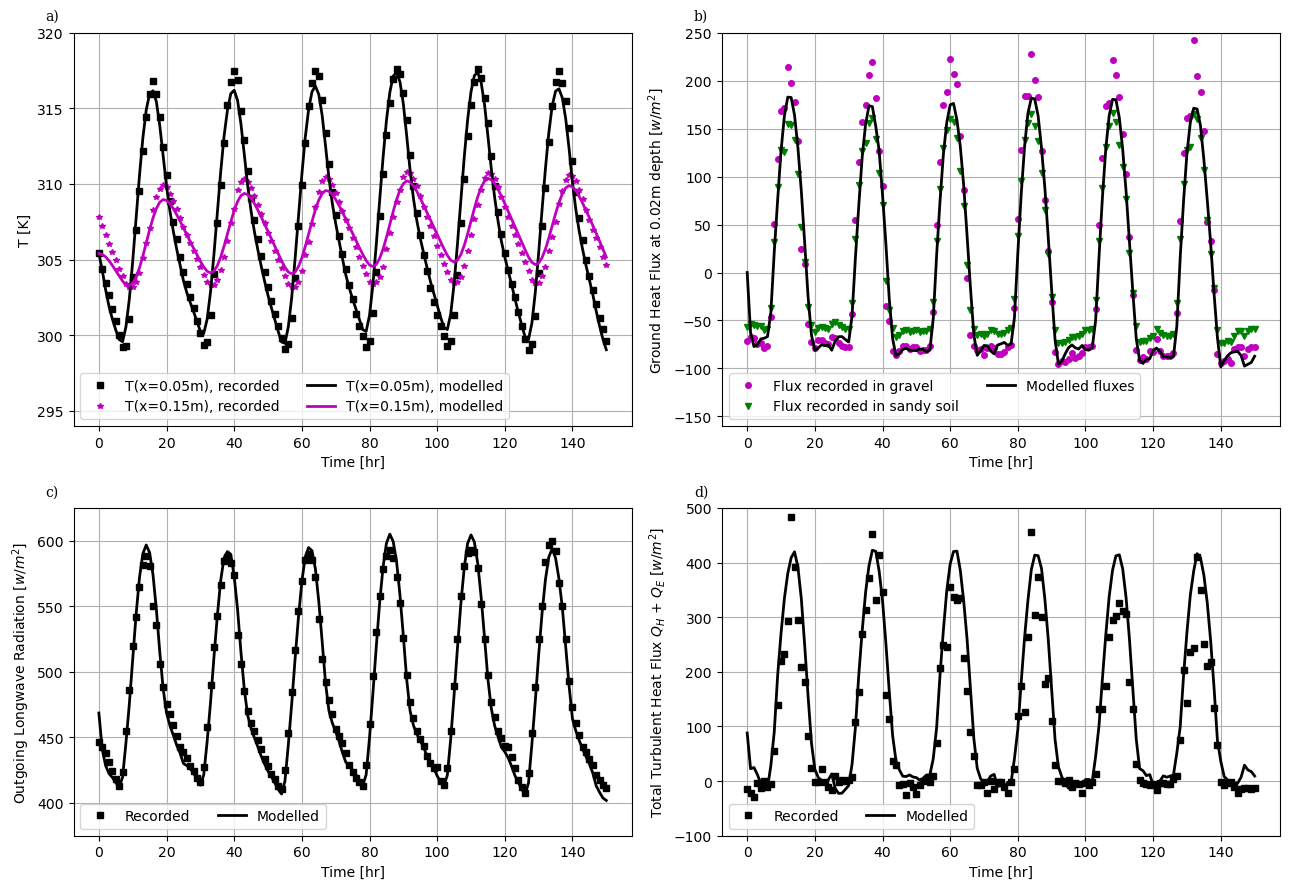

In [51]:
fig,ax = plt.subplots(2,2,figsize=(13,9),gridspec_kw={'height_ratios': [1.2, 1]})

ax[0,0].plot(time/hour,target_T5,'ks',markersize=4,linewidth=1.0,label='T(x=0.05m), recorded')
ax[0,0].plot(time/hour,target_T15,'m*',markersize=4,linewidth=1.0,label='T(x=0.15m), recorded')
ax[0,0].plot(time/hour,output[0,:].detach().numpy(),'k',linewidth=2.0,label='T(x=0.05m), modelled')
ax[0,0].plot(time/hour,output[1,:].detach().numpy(),'m',linewidth=2.0,label='T(x=0.15m), modelled')
#ax[1].plot(time_1stguess/hour,output_1stguess[2,:].detach().numpy(),'g--',label='output_T15')
ax[0,0].legend(loc="lower left", ncol = 2)
ax[0,0].set_ylim([294,320])
ax[0,0].set_xlabel('Time [hr]')
ax[0,0].set_ylabel('T [K]')
ax[0,0].text(
        0.0, 1.0, 'a)', transform=(
            ax[0,0].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
        fontsize='medium', va='bottom', fontfamily='serif')
ax[0,0].grid()
################
Qg_output = Lambda_ex*dTdx_array[0,:].detach().numpy()
Qg_recorded_1 = np.array(df2['shf_Avg'][0::2])
Qg_recorded_2 = np.array(df2['shf_2_Avg'][0::2])
ax[0,1].set_ylim([-160,250])
#plt.plot(time/hour,Qg,linewidth = '2.0',label='SEB residual of recorded fluxes')
ax[0,1].plot(time/hour,Qg_recorded_1,'om',markersize=4,linewidth = '1.0',label='Flux recorded in gravel')
ax[0,1].plot(time/hour,Qg_recorded_2,'vg',markersize=4,linewidth = '1.0',label='Flux recorded in sandy soil')
ax[0,1].plot(time/hour,Qg_output,'k',linewidth = '2.0',label='Modelled fluxes')
ax[0,1].text(
        0.0, 1.0, 'b)', transform=(
            ax[0,1].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
        fontsize='medium', va='bottom', fontfamily='serif')
ax[0,1].set_ylabel(r'Ground Heat Flux at 0.02m depth [$w/m^2$]')
ax[0,1].set_xlabel('Time [hr]')
ax[0,1].legend(loc="lower left", ncol = 2)
ax[0,1].grid()
################
ax[1,0].plot(time/hour,L_up_array,'sk',markersize=4,linewidth=1.0,label = 'Measured flux')
ax[1,0].plot(time/hour,epsilon*sigma*Ts_array.detach().numpy()[0,:]**4,'k',linewidth=2.0,label = 'Modelled flux')

ax[1,0].text(
        0.0, 1.0, 'c)', transform=(
            ax[1,0].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
        fontsize='medium', va='bottom', fontfamily='serif')
ax[1,0].set_ylabel(r'Outgoing Longwave Radiation [$w/m^2$]')
ax[1,0].set_ylim([375,625])
ax[1,0].grid()
ax[1,0].set_xlabel('Time [hr]')
ax[1,0].legend(['Recorded','Modelled'],loc="lower left",ncol=2)
################
ax[1,1].plot(time/hour,QE_array+QH_array,'sk',markersize=4,linewidth=1.0,label = 'Analysis data')
ax[1,1].plot(time/hour,h_beta_ex*(Ts_array.detach().numpy()[0,:]-Ta_array.detach().numpy()),'k',linewidth=2.0,label = 'Modelled flux')

ax[1,1].text(
        0.0, 1.0, 'd)', transform=(
            ax[1,1].transAxes + ScaledTranslation(-20/72, +7/72, fig.dpi_scale_trans)),
        fontsize='medium', va='bottom', fontfamily='serif')
ax[1,1].set_ylabel(r'Total Turbulent Heat Flux $Q_H$ + $Q_E$ [$w/m^2$]')
ax[1,1].set_xlabel('Time [hr]')
ax[1,1].set_ylim([-100,500])
ax[1,1].grid()
ax[1,1].legend(['Recorded','Modelled'],loc="lower left",ncol=2)

fig.tight_layout()
fig.savefig("finaloutput.png")